In [1]:
import pickle
import plotly.graph_objects as go
import numpy as np
from utils import upscale_signal
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import pickle
import pandas as pd

#### Load labels

In [2]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})

main_periodicity = 4307.69 #value from main.ipynb
downsampling_rate = int(main_periodicity/40)
window_size = int(main_periodicity/downsampling_rate)

stride =int(window_size/5)
labels = train_data['Normal/Attack'].values[::downsampling_rate]

### Shape anomaly detection Results

In [3]:
with open("outputs/shape_3_dict_opt_save_pso_NOPCA_STD.pkl", "rb") as f:
    data = pickle.load(f)
    N = len(data)
    loss_original = data[0]["loss_ts"]
    loss_optimized = data[N-1]["loss_ts"]
    loss_original_upscaled = upscale_signal(loss_original, labels.shape[0], stride, window_size, operator=np.maximum)
    loss_optimized_upscaled = upscale_signal(loss_optimized, labels.shape[0], stride, window_size, operator=np.maximum)

In [4]:

labels_abnormal_indices = np.where(labels == 1)[0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(loss_original_upscaled)), y=loss_original_upscaled, mode="lines", name="Loss step 0"))
fig.add_trace(
    go.Scatter(
        x=labels_abnormal_indices, y=loss_optimized_upscaled[labels_abnormal_indices], mode="markers", name="Attack"
    )
)
fig.add_trace(go.Scatter(x=np.arange(len(loss_optimized_upscaled)), y=loss_optimized_upscaled, mode="lines", name="Loss optimized"))



fig.update_layout(
    xaxis_title="points index",
    yaxis_title="reconstruction loss"
)

#### Calculate Precision and Recall depending on threshold


In [25]:
from evaluator import TSEvaluator
min_loss = min(min(loss_optimized_upscaled), min(loss_original_upscaled))
max_loss = max(max(loss_optimized_upscaled), max(loss_original_upscaled))
step = (max_loss - min_loss)/50
threshold= np.arange(min_loss, max_loss, step)
recall_alpha0_optim = []
recall_alpha1_optim = []
precision_optim = []


recall_alpha0_step0 = []
recall_alpha1_step0 = []
precision_step0 = []
for thres in threshold:
    #loss = upscale_signal(total_loss, labels.shape[0], stride, window_size, operator=np.maximum)
    predicted_labels_optim = loss_optimized_upscaled > thres
    predicted_labels_step0 = loss_original_upscaled > thres
    evaluator = TSEvaluator(alpha_recall = 0)
    recall_alpha0_step0.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_step0))
    recall_alpha0_optim.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_optim))
    precision_step0.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_step0))
    precision_optim.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_optim))
    evaluator = TSEvaluator(alpha_recall = 1)
    recall_alpha1_step0.append(evaluator.get_recall(labels, predicted_labels_step0 ))
    recall_alpha1_optim.append(evaluator.get_recall(labels, predicted_labels_optim ))

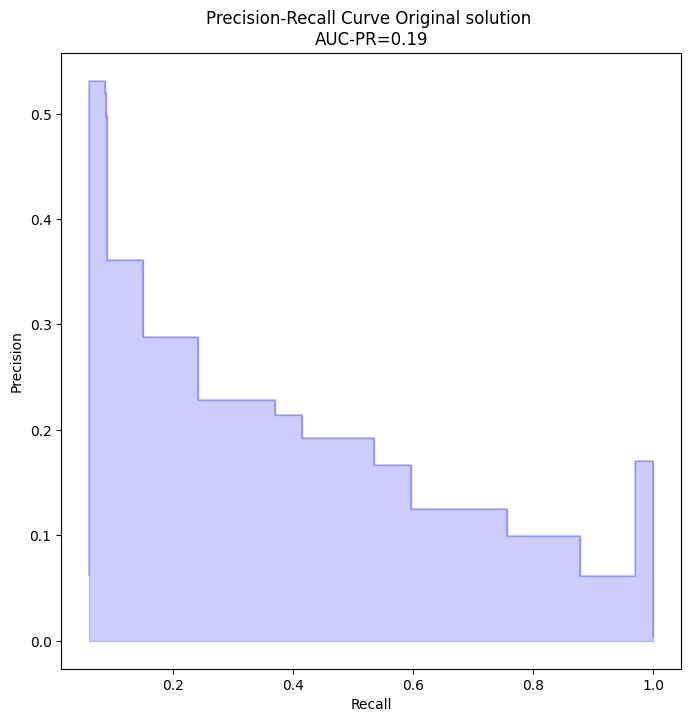

In [26]:
# Compute AUC-PR
auc_pr_original = auc(recall_alpha0_step0, precision_step0)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_step0, precision_step0, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_step0, precision_step0, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Original solution \nAUC-PR={auc_pr_original:.2f}')
plt.show()

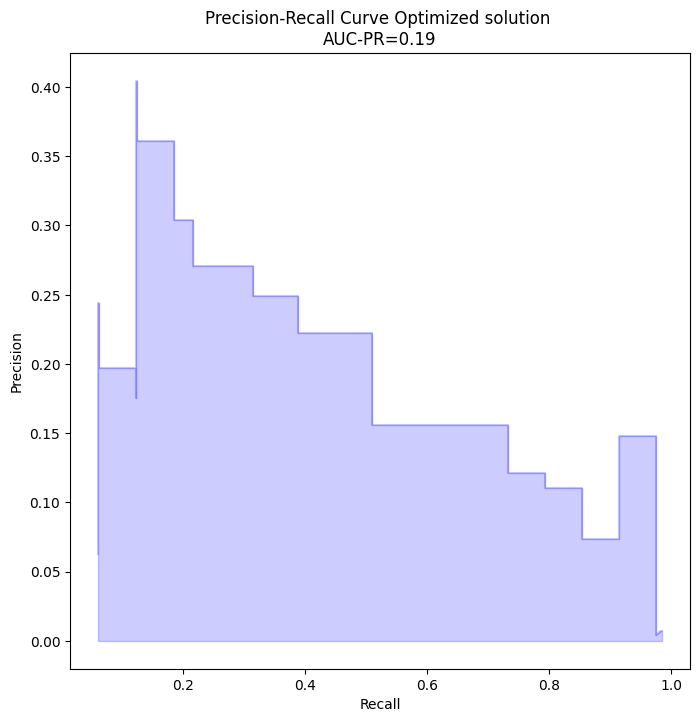

In [27]:
# Compute AUC-PR
auc_pr_optim = auc(recall_alpha0_optim, precision_optim)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_optim, precision_optim, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_optim, precision_optim, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Optimized solution \nAUC-PR={auc_pr_optim:.2f}')
plt.show()

## Amplitude Anomaly results

In [28]:
with open("outputs/3_dict_opt_save_pso_NOPCA_STD.pkl", "rb") as f:
    data = pickle.load(f)
    N = len(data)
    loss_original = data[0]["loss_ts"]
    loss_optimized = data[N-1]["loss_ts"]
    loss_original_upscaled = upscale_signal(loss_original, labels.shape[0], stride, window_size, operator=np.maximum)
    loss_optimized_upscaled = upscale_signal(loss_optimized, labels.shape[0], stride, window_size, operator=np.maximum)

In [29]:

labels_abnormal_indices = np.where(labels == 1)[0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(loss_original_upscaled)), y=loss_original_upscaled, mode="lines", name="Loss step 0"))
fig.add_trace(
    go.Scatter(
        x=labels_abnormal_indices, y=loss_optimized_upscaled[labels_abnormal_indices], mode="markers", name="Attack"
    )
)
fig.add_trace(go.Scatter(x=np.arange(len(loss_optimized_upscaled)), y=loss_optimized_upscaled, mode="lines", name="Loss optimized"))



fig.update_layout(
    xaxis_title="points index",
    yaxis_title="reconstruction loss"
)

### Calculate precision and Recall

In [30]:
from evaluator import TSEvaluator
min_loss = min(min(loss_optimized_upscaled), min(loss_original_upscaled))
max_loss = max(max(loss_optimized_upscaled), max(loss_original_upscaled))
step = (max_loss - min_loss)/50
threshold= np.arange(min_loss, max_loss, step)
recall_alpha0_optim = []
recall_alpha1_optim = []
precision_optim = []


recall_alpha0_step0 = []
recall_alpha1_step0 = []
precision_step0 = []
for thres in threshold:
    #loss = upscale_signal(total_loss, labels.shape[0], stride, window_size, operator=np.maximum)
    predicted_labels_optim = loss_optimized_upscaled > thres
    predicted_labels_step0 = loss_original_upscaled > thres
    evaluator = TSEvaluator(alpha_recall = 0)
    recall_alpha0_step0.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_step0))
    recall_alpha0_optim.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_optim))
    precision_step0.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_step0))
    precision_optim.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_optim))
    evaluator = TSEvaluator(alpha_recall = 1)
    recall_alpha1_step0.append(evaluator.get_recall(labels, predicted_labels_step0 ))
    recall_alpha1_optim.append(evaluator.get_recall(labels, predicted_labels_optim ))

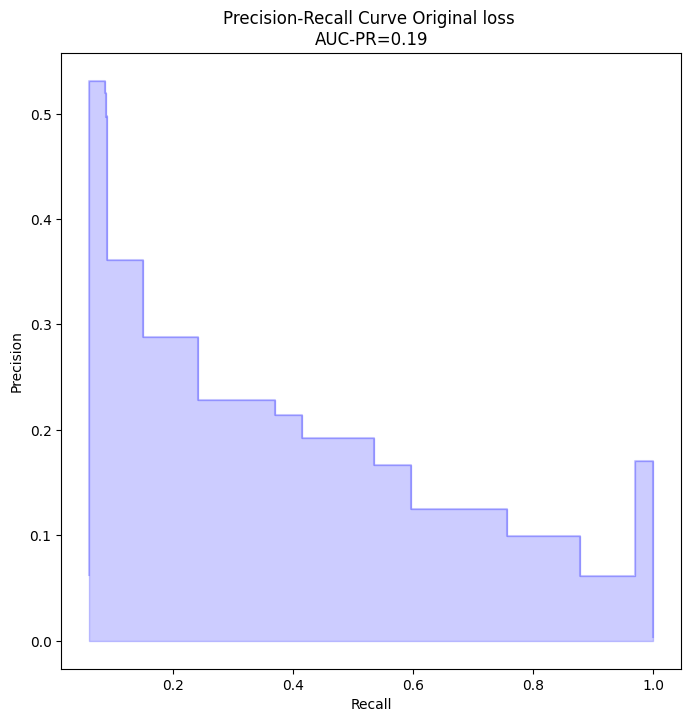

In [31]:
# Compute AUC-PR
auc_pr_original = auc(recall_alpha0_step0, precision_step0)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_step0, precision_step0, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_step0, precision_step0, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Original loss \nAUC-PR={auc_pr_original:.2f}')
plt.show()

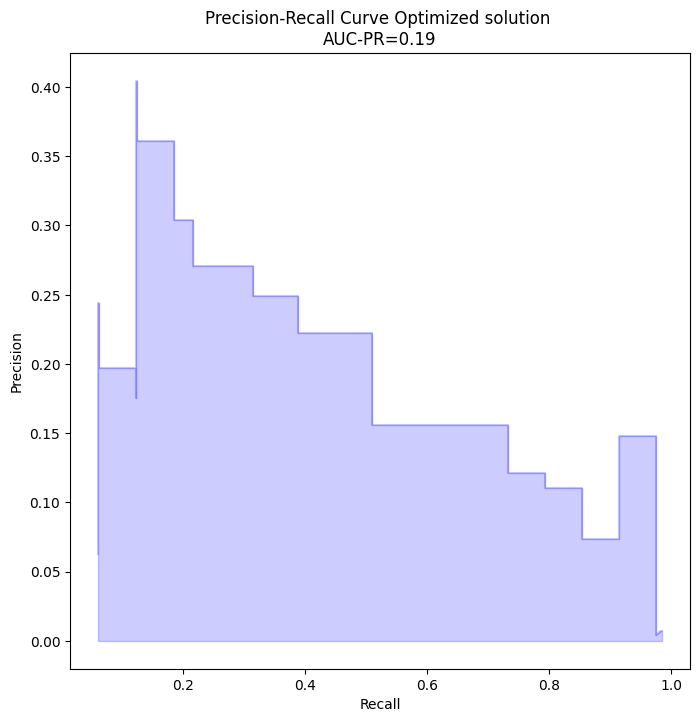

In [32]:
# Compute AUC-PR
auc_pr_optim = auc(recall_alpha0_optim, precision_optim)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_optim , precision_optim, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_optim , precision_optim, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Optimized solution \nAUC-PR={auc_pr_optim:.2f}')
plt.show()